<a href="https://colab.research.google.com/github/NH0917/psp_v1/blob/main/model5.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install polars
!pip install git+https://github.com/Ekeany/Boruta-Shap.git

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Cloning https://github.com/Ekeany/Boruta-Shap.git to /tmp/pip-req-build-5lstta9_
  Running command git clone --filter=blob:none --quiet https://github.com/Ekeany/Boruta-Shap.git /tmp/pip-req-build-5lstta9_
  Resolved https://github.com/Ekeany/Boruta-Shap.git to commit cddb6da69c59b58b9e4d74681202fb0d08ec54f7
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 572.6/572.6 kB 15.8 MB/s eta 0:00:00
  Created wheel for BorutaShap: filename=BorutaShap-1.0.14-py3-none-any.whl size=14948 sha256=19a16904c5f568e2c06e43e7e6589c66995b99e1da5a7f342a44eb1e38e5c7fd
  Stored in directory: /tmp/pip-ephem-wheel-cache-9vvc_36x/wheels/38/dc/b0/f7985c3484aac88d3cc94d6368fdbbd7c662c0bdd7babe730a
Successfully built BorutaShap


In [ ]:
import gc
import os

import pandas as pd
import numpy as np
import warnings
import pickle
import polars as pl
import sys
import os

from collections import defaultdict
from itertools import combinations
import pyarrow as pa
from sklearn.model_selection import GroupKFold
from sklearn.metrics import f1_score

import xgboost as xgb
from xgboost import XGBClassifier
from BorutaShap import BorutaShap, load_data

In [ ]:
train_path = "/content/drive/MyDrive/kaggle/psp/input/train.csv"
label_path = "/content/drive/MyDrive/kaggle/psp/input/train_labels.csv"
output_path = "/content/drive/MyDrive/kaggle/psp/model/model5/output"

In [ ]:
CATS = ['event_name', 'name', 'fqid', 'room_fqid', 'text_fqid']
NUMS = ['page', 'room_coor_x', 'room_coor_y', 'screen_coor_x', 'screen_coor_y',
        'hover_duration', 'elapsed_time_diff']

name_feature = ['basic', 'undefined', 'close', 'open', 'prev', 'next']
event_name_feature = ['cutscene_click', 'person_click', 'navigate_click',
       'observation_click', 'notification_click', 'object_click',
       'object_hover', 'map_hover', 'map_click', 'checkpoint',
       'notebook_click']

# from https://www.kaggle.com/code/leehomhuang/catboost-baseline-with-lots-features-inference :
fqid_lists = ['worker', 'archivist', 'gramps', 'wells', 'toentry', 'confrontation', 'crane_ranger', 'groupconvo', 'flag_girl', 'tomap', 'tostacks', 'tobasement', 'archivist_glasses', 'boss', 'journals', 'seescratches', 'groupconvo_flag', 'cs', 'teddy', 'expert', 'businesscards', 'ch3start', 'tunic.historicalsociety', 'tofrontdesk', 'savedteddy', 'plaque', 'glasses', 'tunic.drycleaner', 'reader_flag', 'tunic.library', 'tracks', 'tunic.capitol_2', 'trigger_scarf', 'reader', 'directory', 'tunic.capitol_1', 'journals.pic_0.next', 'unlockdoor', 'tunic', 'what_happened', 'tunic.kohlcenter', 'tunic.humanecology', 'colorbook', 'logbook', 'businesscards.card_0.next', 'journals.hub.topics', 'logbook.page.bingo', 'journals.pic_1.next', 'journals_flag', 'reader.paper0.next', 'tracks.hub.deer', 'reader_flag.paper0.next', 'trigger_coffee', 'wellsbadge', 'journals.pic_2.next', 'tomicrofiche', 'journals_flag.pic_0.bingo', 'plaque.face.date', 'notebook', 'tocloset_dirty', 'businesscards.card_bingo.bingo', 'businesscards.card_1.next', 'tunic.wildlife', 'tunic.hub.slip', 'tocage', 'journals.pic_2.bingo', 'tocollectionflag', 'tocollection', 'chap4_finale_c', 'chap2_finale_c', 'lockeddoor', 'journals_flag.hub.topics', 'tunic.capitol_0', 'reader_flag.paper2.bingo', 'photo', 'tunic.flaghouse', 'reader.paper1.next', 'directory.closeup.archivist', 'intro', 'businesscards.card_bingo.next', 'reader.paper2.bingo', 'retirement_letter', 'remove_cup', 'journals_flag.pic_0.next', 'magnify', 'coffee', 'key', 'togrampa', 'reader_flag.paper1.next', 'janitor', 'tohallway', 'chap1_finale', 'report', 'outtolunch', 'journals_flag.hub.topics_old', 'journals_flag.pic_1.next', 'reader.paper2.next', 'chap1_finale_c', 'reader_flag.paper2.next', 'door_block_talk', 'journals_flag.pic_1.bingo', 'journals_flag.pic_2.next', 'journals_flag.pic_2.bingo', 'block_magnify', 'reader.paper0.prev', 'block', 'reader_flag.paper0.prev', 'block_0', 'door_block_clean', 'reader.paper2.prev', 'reader.paper1.prev', 'doorblock', 'tocloset', 'reader_flag.paper2.prev', 'reader_flag.paper1.prev', 'block_tomap2', 'journals_flag.pic_0_old.next', 'journals_flag.pic_1_old.next', 'block_tocollection', 'block_nelson', 'journals_flag.pic_2_old.next', 'block_tomap1', 'block_badge', 'need_glasses', 'block_badge_2', 'fox', 'block_1']
text_lists = ['tunic.historicalsociety.cage.confrontation', 'tunic.wildlife.center.crane_ranger.crane', 'tunic.historicalsociety.frontdesk.archivist.newspaper', 'tunic.historicalsociety.entry.groupconvo', 'tunic.wildlife.center.wells.nodeer', 'tunic.historicalsociety.frontdesk.archivist.have_glass', 'tunic.drycleaner.frontdesk.worker.hub', 'tunic.historicalsociety.closet_dirty.gramps.news', 'tunic.humanecology.frontdesk.worker.intro', 'tunic.historicalsociety.frontdesk.archivist_glasses.confrontation', 'tunic.historicalsociety.basement.seescratches', 'tunic.historicalsociety.collection.cs', 'tunic.flaghouse.entry.flag_girl.hello', 'tunic.historicalsociety.collection.gramps.found', 'tunic.historicalsociety.basement.ch3start', 'tunic.historicalsociety.entry.groupconvo_flag', 'tunic.library.frontdesk.worker.hello', 'tunic.library.frontdesk.worker.wells', 'tunic.historicalsociety.collection_flag.gramps.flag', 'tunic.historicalsociety.basement.savedteddy', 'tunic.library.frontdesk.worker.nelson', 'tunic.wildlife.center.expert.removed_cup', 'tunic.library.frontdesk.worker.flag', 'tunic.historicalsociety.frontdesk.archivist.hello', 'tunic.historicalsociety.closet.gramps.intro_0_cs_0', 'tunic.historicalsociety.entry.boss.flag', 'tunic.flaghouse.entry.flag_girl.symbol', 'tunic.historicalsociety.closet_dirty.trigger_scarf', 'tunic.drycleaner.frontdesk.worker.done', 'tunic.historicalsociety.closet_dirty.what_happened', 'tunic.wildlife.center.wells.animals', 'tunic.historicalsociety.closet.teddy.intro_0_cs_0', 'tunic.historicalsociety.cage.glasses.afterteddy', 'tunic.historicalsociety.cage.teddy.trapped', 'tunic.historicalsociety.cage.unlockdoor', 'tunic.historicalsociety.stacks.journals.pic_2.bingo', 'tunic.historicalsociety.entry.wells.flag', 'tunic.humanecology.frontdesk.worker.badger', 'tunic.historicalsociety.stacks.journals_flag.pic_0.bingo', 'tunic.historicalsociety.closet.intro', 'tunic.historicalsociety.closet.retirement_letter.hub', 'tunic.historicalsociety.entry.directory.closeup.archivist', 'tunic.historicalsociety.collection.tunic.slip', 'tunic.kohlcenter.halloffame.plaque.face.date', 'tunic.historicalsociety.closet_dirty.trigger_coffee', 'tunic.drycleaner.frontdesk.logbook.page.bingo', 'tunic.library.microfiche.reader.paper2.bingo', 'tunic.kohlcenter.halloffame.togrampa', 'tunic.capitol_2.hall.boss.haveyougotit', 'tunic.wildlife.center.wells.nodeer_recap', 'tunic.historicalsociety.cage.glasses.beforeteddy', 'tunic.historicalsociety.closet_dirty.gramps.helpclean', 'tunic.wildlife.center.expert.recap', 'tunic.historicalsociety.frontdesk.archivist.have_glass_recap', 'tunic.historicalsociety.stacks.journals_flag.pic_1.bingo', 'tunic.historicalsociety.cage.lockeddoor', 'tunic.historicalsociety.stacks.journals_flag.pic_2.bingo', 'tunic.historicalsociety.collection.gramps.lost', 'tunic.historicalsociety.closet.notebook', 'tunic.historicalsociety.frontdesk.magnify', 'tunic.humanecology.frontdesk.businesscards.card_bingo.bingo', 'tunic.wildlife.center.remove_cup', 'tunic.library.frontdesk.wellsbadge.hub', 'tunic.wildlife.center.tracks.hub.deer', 'tunic.historicalsociety.frontdesk.key', 'tunic.library.microfiche.reader_flag.paper2.bingo', 'tunic.flaghouse.entry.colorbook', 'tunic.wildlife.center.coffee', 'tunic.capitol_1.hall.boss.haveyougotit', 'tunic.historicalsociety.basement.janitor', 'tunic.historicalsociety.collection_flag.gramps.recap', 'tunic.wildlife.center.wells.animals2', 'tunic.flaghouse.entry.flag_girl.symbol_recap', 'tunic.historicalsociety.closet_dirty.photo', 'tunic.historicalsociety.stacks.outtolunch', 'tunic.library.frontdesk.worker.wells_recap', 'tunic.historicalsociety.frontdesk.archivist_glasses.confrontation_recap', 'tunic.capitol_0.hall.boss.talktogramps', 'tunic.historicalsociety.closet.photo', 'tunic.historicalsociety.collection.tunic', 'tunic.historicalsociety.closet.teddy.intro_0_cs_5', 'tunic.historicalsociety.closet_dirty.gramps.archivist', 'tunic.historicalsociety.closet_dirty.door_block_talk', 'tunic.historicalsociety.entry.boss.flag_recap', 'tunic.historicalsociety.frontdesk.archivist.need_glass_0', 'tunic.historicalsociety.entry.wells.talktogramps', 'tunic.historicalsociety.frontdesk.block_magnify', 'tunic.historicalsociety.frontdesk.archivist.foundtheodora', 'tunic.historicalsociety.closet_dirty.gramps.nothing', 'tunic.historicalsociety.closet_dirty.door_block_clean', 'tunic.capitol_1.hall.boss.writeitup', 'tunic.library.frontdesk.worker.nelson_recap', 'tunic.library.frontdesk.worker.hello_short', 'tunic.historicalsociety.stacks.block', 'tunic.historicalsociety.frontdesk.archivist.need_glass_1', 'tunic.historicalsociety.entry.boss.talktogramps', 'tunic.historicalsociety.frontdesk.archivist.newspaper_recap', 'tunic.historicalsociety.entry.wells.flag_recap', 'tunic.drycleaner.frontdesk.worker.done2', 'tunic.library.frontdesk.worker.flag_recap', 'tunic.humanecology.frontdesk.block_0', 'tunic.library.frontdesk.worker.preflag', 'tunic.historicalsociety.basement.gramps.seeyalater', 'tunic.flaghouse.entry.flag_girl.hello_recap', 'tunic.historicalsociety.closet.doorblock', 'tunic.drycleaner.frontdesk.worker.takealook', 'tunic.historicalsociety.basement.gramps.whatdo', 'tunic.library.frontdesk.worker.droppedbadge', 'tunic.historicalsociety.entry.block_tomap2', 'tunic.library.frontdesk.block_nelson', 'tunic.library.microfiche.block_0', 'tunic.historicalsociety.entry.block_tocollection', 'tunic.historicalsociety.entry.block_tomap1', 'tunic.historicalsociety.collection.gramps.look_0', 'tunic.library.frontdesk.block_badge', 'tunic.historicalsociety.cage.need_glasses', 'tunic.library.frontdesk.block_badge_2', 'tunic.kohlcenter.halloffame.block_0', 'tunic.capitol_0.hall.chap1_finale_c', 'tunic.capitol_1.hall.chap2_finale_c', 'tunic.capitol_2.hall.chap4_finale_c', 'tunic.wildlife.center.fox.concern', 'tunic.drycleaner.frontdesk.block_0', 'tunic.historicalsociety.entry.gramps.hub', 'tunic.humanecology.frontdesk.block_1', 'tunic.drycleaner.frontdesk.block_1']
room_lists = ['tunic.historicalsociety.entry', 'tunic.wildlife.center', 'tunic.historicalsociety.cage', 'tunic.library.frontdesk', 'tunic.historicalsociety.frontdesk', 'tunic.historicalsociety.stacks', 'tunic.historicalsociety.closet_dirty', 'tunic.humanecology.frontdesk', 'tunic.historicalsociety.basement', 'tunic.kohlcenter.halloffame', 'tunic.library.microfiche', 'tunic.drycleaner.frontdesk', 'tunic.historicalsociety.collection', 'tunic.historicalsociety.closet', 'tunic.flaghouse.entry', 'tunic.historicalsociety.collection_flag', 'tunic.capitol_1.hall', 'tunic.capitol_0.hall', 'tunic.capitol_2.hall']


def feature_enginner_pl(x,grp,use_extra,feature_suffix):

    aggs = [
        pl.col("index").count().alias(f"session_number_{feature_suffix}"),
        *[pl.col(c).drop_nulls().n_unique().alias(f"{c}_unique_{feature_suffix}") for c in CATS],

        *[pl.col(c).quantile(0.1,"nearest").alias(f"{c}_quantile1_{feature_suffix}") for c in NUMS],
        *[pl.col(c).quantile(0.2,"nearest").alias(f"{c}_quantile2_{feature_suffix}") for c in NUMS],
        *[pl.col(c).quantile(0.3,"nearest").alias(f"{c}_quantile3_{feature_suffix}") for c in NUMS],
        *[pl.col(c).quantile(0.4,"nearest").alias(f"{c}_quantile4_{feature_suffix}") for c in NUMS],
        *[pl.col(c).quantile(0.5,"nearest").alias(f"{c}_quantile5_{feature_suffix}") for c in NUMS],
        *[pl.col(c).quantile(0.6,"nearest").alias(f"{c}_quantile6_{feature_suffix}") for c in NUMS],
        *[pl.col(c).quantile(0.7,"nearest").alias(f"{c}_quantile7_{feature_suffix}") for c in NUMS],
        *[pl.col(c).quantile(0.8,"nearest").alias(f"{c}_quantile8_{feature_suffix}") for c in NUMS],
        *[pl.col(c).quantile(0.9,"nearest").alias(f"{c}_quantile9_{feature_suffix}") for c in NUMS],

        *[pl.col(c).mean().alias(f"{c}_mean_{feature_suffix}") for c in NUMS],
        *[pl.col(c).std().alias(f"{c}_std_{feature_suffix}") for c in NUMS],
        *[pl.col(c).min().alias(f"{c}_min_{feature_suffix}") for c in NUMS],
        *[pl.col(c).max().alias(f"{c}_max_{feature_suffix}") for c in NUMS],


        #Event name feature
        *[pl.col("event_name").filter(pl.col("event_name") == c).count().alias(f"{c}_event_name_counts{feature_suffix}") for c in event_name_feature],
        *[pl.col("elapsed_time_diff").filter(pl.col("event_name") == c).mean().alias(f"{c}_ET_mean_{feature_suffix}") for c in event_name_feature],
        *[pl.col("elapsed_time_diff").filter(pl.col("event_name") == c).std().alias(f"{c}_ET_std_{feature_suffix}") for c in event_name_feature],
        *[pl.col("elapsed_time_diff").filter(pl.col("event_name") == c).max().alias(f"{c}_ET_max_{feature_suffix}") for c in event_name_feature],
        *[pl.col("elapsed_time_diff").filter(pl.col("event_name") == c).min().alias(f"{c}_ET_min_{feature_suffix}") for c in event_name_feature],
        *[pl.col("elapsed_time_diff").filter(pl.col("event_name") == c).sum().alias(f"{c}_ET_sum_{feature_suffix}") for c in event_name_feature],

        *[pl.col("elapsed_time_diff").filter(pl.col("event_name") == c).quantile(0.1,"nearest").alias(f"{c}_ET_quantile1_{feature_suffix}") for c in event_name_feature],
        *[pl.col("elapsed_time_diff").filter(pl.col("event_name") == c).quantile(0.2,"nearest").alias(f"{c}_ET_quantile2_{feature_suffix}") for c in event_name_feature],
        *[pl.col("elapsed_time_diff").filter(pl.col("event_name") == c).quantile(0.3,"nearest").alias(f"{c}_ET_quantile3_{feature_suffix}") for c in event_name_feature],
        *[pl.col("elapsed_time_diff").filter(pl.col("event_name") == c).quantile(0.4,"nearest").alias(f"{c}_ET_quantile4_{feature_suffix}") for c in event_name_feature],
        *[pl.col("elapsed_time_diff").filter(pl.col("event_name") == c).quantile(0.5,"nearest").alias(f"{c}_ET_quantile5_{feature_suffix}") for c in event_name_feature],
        *[pl.col("elapsed_time_diff").filter(pl.col("event_name") == c).quantile(0.6,"nearest").alias(f"{c}_ET_quantile6_{feature_suffix}") for c in event_name_feature],
        *[pl.col("elapsed_time_diff").filter(pl.col("event_name") == c).quantile(0.7,"nearest").alias(f"{c}_ET_quantile7_{feature_suffix}") for c in event_name_feature],
        *[pl.col("elapsed_time_diff").filter(pl.col("event_name") == c).quantile(0.8,"nearest").alias(f"{c}_ET_quantile8_{feature_suffix}") for c in event_name_feature],
        *[pl.col("elapsed_time_diff").filter(pl.col("event_name") == c).quantile(0.9,"nearest").alias(f"{c}_ET_quantile9_{feature_suffix}") for c in event_name_feature],

        #Name feature
        *[pl.col("name").filter(pl.col("name") == c).count().alias(f"{c}_name_counts{feature_suffix}") for c in name_feature],
        *[pl.col("elapsed_time_diff").filter(pl.col("name") == c).mean().alias(f"{c}_ET_mean_{feature_suffix}") for c in name_feature],
        *[pl.col("elapsed_time_diff").filter(pl.col("name") == c).max().alias(f"{c}_ET_max_{feature_suffix}") for c in name_feature],
        *[pl.col("elapsed_time_diff").filter(pl.col("name") == c).min().alias(f"{c}_ET_min_{feature_suffix}") for c in name_feature],
        *[pl.col("elapsed_time_diff").filter(pl.col("name") == c).std().alias(f"{c}_ET_std_{feature_suffix}") for c in name_feature],
        *[pl.col("elapsed_time_diff").filter(pl.col("name") == c).sum().alias(f"{c}_ET_sum_{feature_suffix}") for c in name_feature],

        *[pl.col("elapsed_time_diff").filter(pl.col("name") == c).quantile(0.1,"nearest").alias(f"{c}_ET_quantile1_{feature_suffix}") for c in name_feature],
        *[pl.col("elapsed_time_diff").filter(pl.col("name") == c).quantile(0.2,"nearest").alias(f"{c}_ET_quantile2_{feature_suffix}") for c in name_feature],
        *[pl.col("elapsed_time_diff").filter(pl.col("name") == c).quantile(0.3,"nearest").alias(f"{c}_ET_quantile3_{feature_suffix}") for c in name_feature],
        *[pl.col("elapsed_time_diff").filter(pl.col("name") == c).quantile(0.4,"nearest").alias(f"{c}_ET_quantile4_{feature_suffix}") for c in name_feature],
        *[pl.col("elapsed_time_diff").filter(pl.col("name") == c).quantile(0.5,"nearest").alias(f"{c}_ET_quantile5_{feature_suffix}") for c in name_feature],
        *[pl.col("elapsed_time_diff").filter(pl.col("name") == c).quantile(0.6,"nearest").alias(f"{c}_ET_quantile6_{feature_suffix}") for c in name_feature],
        *[pl.col("elapsed_time_diff").filter(pl.col("name") == c).quantile(0.7,"nearest").alias(f"{c}_ET_quantile7_{feature_suffix}") for c in name_feature],
        *[pl.col("elapsed_time_diff").filter(pl.col("name") == c).quantile(0.8,"nearest").alias(f"{c}_ET_quantile8_{feature_suffix}") for c in name_feature],
        *[pl.col("elapsed_time_diff").filter(pl.col("name") == c).quantile(0.9,"nearest").alias(f"{c}_ET_quantile9_{feature_suffix}") for c in name_feature],


        #room list feature
        *[pl.col("room_fqid").filter(pl.col("room_fqid") == c).count().alias(f"{c}_room_fqid_counts{feature_suffix}") for c in room_lists],
        *[pl.col("elapsed_time_diff").filter(pl.col("room_fqid") == c).std().alias(f"{c}_ET_std_{feature_suffix}") for c in room_lists],
        *[pl.col("elapsed_time_diff").filter(pl.col("room_fqid") == c).mean().alias(f"{c}_ET_mean_{feature_suffix}") for c in room_lists],
        *[pl.col("elapsed_time_diff").filter(pl.col("room_fqid") == c).max().alias(f"{c}_ET_max_{feature_suffix}") for c in room_lists],
        *[pl.col("elapsed_time_diff").filter(pl.col("room_fqid") == c).min().alias(f"{c}_ET_min_{feature_suffix}") for c in room_lists],
        *[pl.col("elapsed_time_diff").filter(pl.col("room_fqid") == c).sum().alias(f"{c}_ET_sum_{feature_suffix}") for c in room_lists],

        *[pl.col("elapsed_time_diff").filter(pl.col("room_fqid") == c).quantile(0.1,"nearest").alias(f"{c}_ET_quantile1_{feature_suffix}") for c in room_lists],
        *[pl.col("elapsed_time_diff").filter(pl.col("room_fqid") == c).quantile(0.2,"nearest").alias(f"{c}_ET_quantile2_{feature_suffix}") for c in room_lists],
        *[pl.col("elapsed_time_diff").filter(pl.col("room_fqid") == c).quantile(0.3,"nearest").alias(f"{c}_ET_quantile3_{feature_suffix}") for c in room_lists],
        *[pl.col("elapsed_time_diff").filter(pl.col("room_fqid") == c).quantile(0.4,"nearest").alias(f"{c}_ET_quantile4_{feature_suffix}") for c in room_lists],
        *[pl.col("elapsed_time_diff").filter(pl.col("room_fqid") == c).quantile(0.5,"nearest").alias(f"{c}_ET_quantile5_{feature_suffix}") for c in room_lists],
        *[pl.col("elapsed_time_diff").filter(pl.col("room_fqid") == c).quantile(0.6,"nearest").alias(f"{c}_ET_quantile6_{feature_suffix}") for c in room_lists],
        *[pl.col("elapsed_time_diff").filter(pl.col("room_fqid") == c).quantile(0.7,"nearest").alias(f"{c}_ET_quantile7_{feature_suffix}") for c in room_lists],
        *[pl.col("elapsed_time_diff").filter(pl.col("room_fqid") == c).quantile(0.8,"nearest").alias(f"{c}_ET_quantile8_{feature_suffix}") for c in room_lists],
        *[pl.col("elapsed_time_diff").filter(pl.col("room_fqid") == c).quantile(0.9,"nearest").alias(f"{c}_ET_quantile9_{feature_suffix}") for c in room_lists],

        #fqid list features
        *[pl.col("fqid").filter(pl.col("fqid") == c).count().alias(f"{c}_fqid_counts{feature_suffix}") for c in fqid_lists],
        *[pl.col("elapsed_time_diff").filter(pl.col("fqid") == c).std().alias(f"{c}_ET_std_{feature_suffix}") for c in fqid_lists],
        *[pl.col("elapsed_time_diff").filter(pl.col("fqid") == c).mean().alias(f"{c}_ET_mean_{feature_suffix}") for c in fqid_lists],
        *[pl.col("elapsed_time_diff").filter(pl.col("fqid") == c).max().alias(f"{c}_ET_max_{feature_suffix}") for c in fqid_lists],
        *[pl.col("elapsed_time_diff").filter(pl.col("fqid") == c).min().alias(f"{c}_ET_min_{feature_suffix}") for c in fqid_lists],
        *[pl.col("elapsed_time_diff").filter(pl.col("fqid") == c).sum().alias(f"{c}_ET_sum_{feature_suffix}") for c in fqid_lists],

        *[pl.col("elapsed_time_diff").filter(pl.col("fqid") == c).quantile(0.1,"nearest").alias(f"{c}_ET_quantile1_{feature_suffix}") for c in fqid_lists],
        *[pl.col("elapsed_time_diff").filter(pl.col("fqid") == c).quantile(0.2,"nearest").alias(f"{c}_ET_quantile2_{feature_suffix}") for c in fqid_lists],
        *[pl.col("elapsed_time_diff").filter(pl.col("fqid") == c).quantile(0.3,"nearest").alias(f"{c}_ET_quantile3_{feature_suffix}") for c in fqid_lists],
        *[pl.col("elapsed_time_diff").filter(pl.col("fqid") == c).quantile(0.4,"nearest").alias(f"{c}_ET_quantile4_{feature_suffix}") for c in fqid_lists],
        *[pl.col("elapsed_time_diff").filter(pl.col("fqid") == c).quantile(0.5,"nearest").alias(f"{c}_ET_quantile5_{feature_suffix}") for c in fqid_lists],
        *[pl.col("elapsed_time_diff").filter(pl.col("fqid") == c).quantile(0.6,"nearest").alias(f"{c}_ET_quantile6_{feature_suffix}") for c in fqid_lists],
        *[pl.col("elapsed_time_diff").filter(pl.col("fqid") == c).quantile(0.7,"nearest").alias(f"{c}_ET_quantile7_{feature_suffix}") for c in fqid_lists],
        *[pl.col("elapsed_time_diff").filter(pl.col("fqid") == c).quantile(0.8,"nearest").alias(f"{c}_ET_quantile8_{feature_suffix}") for c in fqid_lists],
        *[pl.col("elapsed_time_diff").filter(pl.col("fqid") == c).quantile(0.9,"nearest").alias(f"{c}_ET_quantile9_{feature_suffix}") for c in fqid_lists],

        #text list features
        *[pl.col("text_fqid").filter(pl.col("text_fqid") == c).count().alias(f"{c}_text_fqid_counts{feature_suffix}") for c in text_lists],
        *[pl.col("elapsed_time_diff").filter(pl.col("text_fqid") == c).std().alias(f"{c}_ET_std_{feature_suffix}") for c in text_lists],
        *[pl.col("elapsed_time_diff").filter(pl.col("text_fqid") == c).mean().alias(f"{c}_ET_mean_{feature_suffix}") for c in text_lists],
        *[pl.col("elapsed_time_diff").filter(pl.col("text_fqid") == c).max().alias(f"{c}_ET_max_{feature_suffix}") for c in text_lists],
        *[pl.col("elapsed_time_diff").filter(pl.col("text_fqid") == c).min().alias(f"{c}_ET_min_{feature_suffix}") for c in text_lists],
        *[pl.col("elapsed_time_diff").filter(pl.col("text_fqid") == c).sum().alias(f"{c}_ET_sum_{feature_suffix}") for c in text_lists],

        *[pl.col("elapsed_time_diff").filter(pl.col("text_fqid") == c).quantile(0.1,"nearest").alias(f"{c}_ET_quantile1_{feature_suffix}") for c in text_lists],
        *[pl.col("elapsed_time_diff").filter(pl.col("text_fqid") == c).quantile(0.2,"nearest").alias(f"{c}_ET_quantile2_{feature_suffix}") for c in text_lists],
        *[pl.col("elapsed_time_diff").filter(pl.col("text_fqid") == c).quantile(0.3,"nearest").alias(f"{c}_ET_quantile3_{feature_suffix}") for c in text_lists],
        *[pl.col("elapsed_time_diff").filter(pl.col("text_fqid") == c).quantile(0.4,"nearest").alias(f"{c}_ET_quantile4_{feature_suffix}") for c in text_lists],
        *[pl.col("elapsed_time_diff").filter(pl.col("text_fqid") == c).quantile(0.5,"nearest").alias(f"{c}_ET_quantile5_{feature_suffix}") for c in text_lists],
        *[pl.col("elapsed_time_diff").filter(pl.col("text_fqid") == c).quantile(0.6,"nearest").alias(f"{c}_ET_quantile6_{feature_suffix}") for c in text_lists],
        *[pl.col("elapsed_time_diff").filter(pl.col("text_fqid") == c).quantile(0.7,"nearest").alias(f"{c}_ET_quantile7_{feature_suffix}") for c in text_lists],
        *[pl.col("elapsed_time_diff").filter(pl.col("text_fqid") == c).quantile(0.8,"nearest").alias(f"{c}_ET_quantile8_{feature_suffix}") for c in text_lists],
        *[pl.col("elapsed_time_diff").filter(pl.col("text_fqid") == c).quantile(0.9,"nearest").alias(f"{c}_ET_quantile9_{feature_suffix}") for c in text_lists],

        #location features
        *[pl.col("location_x_diff").filter(pl.col("event_name")==c).mean().alias(f"{c}_ET_mean_x{feature_suffix}") for c in event_name_feature],
        *[pl.col("location_x_diff").filter(pl.col("event_name")==c).std().alias(f"{c}_ET_std_x{feature_suffix}") for c in event_name_feature],
        *[pl.col("location_x_diff").filter(pl.col("event_name")==c).max().alias(f"{c}_ET_max_x{feature_suffix}") for c in event_name_feature],
        *[pl.col("location_x_diff").filter(pl.col("event_name")==c).min().alias(f"{c}_ET_min_x{feature_suffix}") for c in event_name_feature],

    ]

    df = x.groupby(["session_id"],maintain_order=True).agg(aggs).sort("session_id")

    if use_extra:
        if grp=='5-12':
            aggs = [
                pl.col("elapsed_time").filter((pl.col("text")=="Here's the log book.")|(pl.col("fqid")=='logbook.page.bingo')).apply(lambda s: s.max()-s.min()).alias("logbook_bingo_duration"),
                pl.col("index").filter((pl.col("text")=="Here's the log book.")|(pl.col("fqid")=='logbook.page.bingo')).apply(lambda s: s.max()-s.min()).alias("logbook_bingo_indexCount"),
                pl.col("elapsed_time").filter(((pl.col("event_name")=='navigate_click')&(pl.col("fqid")=='reader'))|(pl.col("fqid")=="reader.paper2.bingo")).apply(lambda s: s.max()-s.min()).alias("reader_bingo_duration"),
                pl.col("index").filter(((pl.col("event_name")=='navigate_click')&(pl.col("fqid")=='reader'))|(pl.col("fqid")=="reader.paper2.bingo")).apply(lambda s: s.max()-s.min()).alias("reader_bingo_indexCount"),
                pl.col("elapsed_time").filter(((pl.col("event_name")=='navigate_click')&(pl.col("fqid")=='journals'))|(pl.col("fqid")=="journals.pic_2.bingo")).apply(lambda s: s.max()-s.min()).alias("journals_bingo_duration"),
                pl.col("index").filter(((pl.col("event_name")=='navigate_click')&(pl.col("fqid")=='journals'))|(pl.col("fqid")=="journals.pic_2.bingo")).apply(lambda s: s.max()-s.min()).alias("journals_bingo_indexCount"),
            ]
            tmp = x.groupby(["session_id"], maintain_order=True).agg(aggs).sort("session_id")
            df = df.join(tmp, on="session_id", how='left')

        if grp=='13-22':
            aggs = [
                pl.col("elapsed_time").filter(((pl.col("event_name")=='navigate_click')&(pl.col("fqid")=='reader_flag'))|(pl.col("fqid")=="tunic.library.microfiche.reader_flag.paper2.bingo")).apply(lambda s: s.max()-s.min() if s.len()>0 else 0).alias("reader_flag_duration"),
                pl.col("index").filter(((pl.col("event_name")=='navigate_click')&(pl.col("fqid")=='reader_flag'))|(pl.col("fqid")=="tunic.library.microfiche.reader_flag.paper2.bingo")).apply(lambda s: s.max()-s.min() if s.len()>0 else 0).alias("reader_flag_indexCount"),
                pl.col("elapsed_time").filter(((pl.col("event_name")=='navigate_click')&(pl.col("fqid")=='journals_flag'))|(pl.col("fqid")=="journals_flag.pic_0.bingo")).apply(lambda s: s.max()-s.min() if s.len()>0 else 0).alias("journalsFlag_bingo_duration"),
                pl.col("index").filter(((pl.col("event_name")=='navigate_click')&(pl.col("fqid")=='journals_flag'))|(pl.col("fqid")=="journals_flag.pic_0.bingo")).apply(lambda s: s.max()-s.min() if s.len()>0 else 0).alias("journalsFlag_bingo_indexCount"),
            ]
            tmp = x.groupby(["session_id"], maintain_order=True).agg(aggs).sort("session_id")
            df = df.join(tmp, on="session_id", how='left')

    return df.to_pandas()

def preprocessing(feature_path,target_path=None):

    columns = [
    pl.col("page").cast(pl.Float32),
    (
        (pl.col("elapsed_time") - pl.col("elapsed_time").shift(1))
        .fill_null(0)
        .clip(0,1e9)
        .over(["session_id","level_group"])
        .alias("elapsed_time_diff")
    ),
    (
        (pl.col("screen_coor_x") - pl.col("screen_coor_x").shift(1))
        .abs()
        .over(["session_id","level_group"])
        .alias("location_x_diff")
    ),
    (
        (pl.col("screen_coor_y") - pl.col("screen_coor_y").shift(1))
        .abs()
        .over(["session_id","level_group"])
        .alias("location_y_diff")
    ),
    pl.col("fqid").fill_null("fqid_None"),
    pl.col("text_fqid").fill_null("text_fqid_None")
    ]

    df = pl.read_csv(feature_path).drop(["fullscreen", "hq", "music"]).with_columns(columns)
    df1 = df.filter(pl.col("level_group") == "0-4")
    df2 = df.filter(pl.col("level_group") == "5-12")
    df3 = df.filter(pl.col("level_group") == "13-22")

    del df
    gc.collect()

    df1 = feature_enginner_pl(df1,grp="0-4",use_extra=True,feature_suffix="")
    print('df1 done',df1.shape)
    df2 = feature_enginner_pl(df2,grp="5-12",use_extra=True,feature_suffix="")
    print('df2 done',df2.shape)
    df3 = feature_enginner_pl(df3,grp="13-22",use_extra=True,feature_suffix="")
    print('df3 done',df3.shape)


    if target_path:
        targets = pd.read_csv(target_path)
        targets['session'] = targets.session_id.apply(lambda x: int(x.split('_')[0]))
        targets['q'] = targets.session_id.apply(lambda x: int(x.split('_')[-1][1:]))

    return df1,df2,df3,targets

In [ ]:
df1,df2,df3,targets = preprocessing(train_path,label_path)

df1 done (23562, 4477)
df2 done (23562, 4483)
df3 done (23562, 4481)


In [ ]:
boruta_xgb_params = {
    'objective' : 'binary:logistic',
    'eval_metric':'logloss',
    'learning_rate': 0.05,
    'max_depth': 4,
    'n_estimators': 300,
    #'num_class':2,
    #'early_stopping_rounds': 50,
    'tree_method':'hist',
    'subsample':0.8,
    'colsample_bytree': 0.4,
    'tree_method' :'gpu_hist',
    'use_label_encoder' : False}

xgb_params = {
    'objective' : 'binary:logistic',
    'eval_metric':'logloss',
    'learning_rate': 0.05,
    'max_depth': 4,
    'n_estimators': 1000,
    #'num_class':2,
    'early_stopping_rounds': 50,
    'tree_method':'hist',
    'subsample':0.8,
    'colsample_bytree': 0.4,
    'tree_method' :'gpu_hist',
    'use_label_encoder' : False}

In [ ]:
gkf = GroupKFold(n_splits=5)
ALL_USERS = df1.session_id.unique()
oof = pd.DataFrame(np.zeros((len(ALL_USERS),18)),index=ALL_USERS)
FEATURECOL = df1.columns.tolist()
FEATURECOL.remove("session_id")
models = {}

In [ ]:
def threshold(predict_proba,target):

  bst_score = 0
  bst_threshold = 0

  for threshold in np.arange(0.4,1,0.01):
    preds = (predict_proba > threshold).astype("int")
    m = f1_score(target,preds,average="macro")

    if m > bst_score:
      bst_score = m
      bst_threshold = threshold

  return bst_threshold

In [ ]:
for i,(train_idx,valid_idx) in enumerate(gkf.split(X=df1,groups=df1.index)):
    print(f"fold {i}")
    selected_columns = list()
    for t in range(1,4):
      if t ==1:
        df = df1
        y = targets.query("q<=3").drop(columns="session_id")
      elif t==2:
        df = df2
        y = targets.query("4<=q<=13").drop(columns="session_id")
      elif t==3:
        df = df3
        y = targets.query("14<=q").drop(columns="session_id")

      df = df.merge(y,left_on="session_id",right_on="session",how="right")

      #train data
      train_x = df.iloc[train_idx].set_index("session_id")
      train_users = train_x.index.values
      train_x = train_x[FEATURECOL]
      train_y = df.iloc[train_idx]["correct"]

      #valid data
      valid_x = df.iloc[valid_idx].set_index("session_id")
      valid_users = valid_x.index.values
      valid_x = valid_x[FEATURECOL]
      valid_y = df.iloc[valid_idx]["correct"]

      XGB = XGBClassifier(**boruta_xgb_params)
      fs = BorutaShap(model=XGB,importance_measure="shap",classification=True)
      fs.fit(X=train_x,y=train_y,n_trials=50,train_or_test = 'test')
      selected_columns.append(sorted(fs.Subset().columns))


      dtrain = xgb.DMatrix(train_x[fs.Subset().columns],train_y)
      dvalid = xgb.DMatrix(valid_x[fs.Subset().columns],valid_y)

      evals = [(dtrain,"train"),(dvalid,"valid")]
      bst = xgb.train(xgb_params,num_boost_round=50_000,early_stopping_rounds=50,dtrain=dtrain,evals=evals,verbose_eval=100)

      if t == 1:
        oof.loc[valid_users,[0,1,2]] = bst.predict(dvalid)
      if t == 2:
        oof.loc[valid_users,[3,4,5,6,7,8,9,10,11,12]] = bst.predict(dvalid)
      if t == 3:
        oof.loc[valid_users,[13,14,15,16,17]] = bst.predict(dvalid)


      os.makedirs(output_path,exist_ok=True)
      model_path = os.path.join(output_path,f"XGB_fold{i}_section{t}.pickle")

      with open(model_path,"wb") as f:
        pickle.dump(bst,f)

fold 0
Warning there are missing values in your data !


  0%|          | 0/50 [00:00<?, ?it/s]

23 attributes confirmed important: ['checkpoint_ET_min_', 'cutscene_click_ET_quantile4_', 'report_ET_max_', 'notebook_click_ET_quantile8_', 'tunic.historicalsociety.collection.cs_ET_quantile4_', 'object_click_event_name_counts', 'chap1_finale_c_ET_sum_', 'tunic.capitol_0.hall_ET_quantile5_', 'cs_ET_quantile6_', 'tunic.historicalsociety.collection.gramps.found_ET_quantile3_', 'tunic.historicalsociety.collection.gramps.found_ET_sum_', 'chap1_finale_ET_std_', 'chap1_finale_c_ET_quantile5_', 'tunic.capitol_0.hall_ET_sum_', 'plaque_ET_sum_', 'chap1_finale_c_ET_quantile7_', 'open_ET_sum_', 'plaque_fqid_counts', 'basic_name_counts', 'checkpoint_ET_sum_', 'tunic.historicalsociety.collection_room_fqid_counts', 'cutscene_click_ET_quantile5_', 'report_ET_quantile9_']
4446 attributes confirmed unimportant: ['reader_flag.paper1.prev_ET_quantile6_', 'tunic.wildlife.center.expert.removed_cup_ET_quantile8_', 'journals_flag.hub.topics_old_ET_quantile5_', 'room_coor_x_min_', 'tunic.flaghouse.entry.flag_

ValueError: ignored

In [ ]:
true = oof.copy()
for k in range(18):
    # GET TRUE LABELS
    tmp = targets.loc[targets.q == k+1].set_index('session').loc[ALL_USERS]
    true[k] = tmp.correct.values

In [ ]:
true

In [ ]:
oof

In [ ]:
scores = []; thresholds = []
best_score = 0; best_threshold = 0

for threshold in np.arange(0,0.81,0.01):
    print(f'{threshold:.02f}, ',end='')
    preds = (oof.values.reshape((-1))>threshold).astype('int')
    m = f1_score(true.values.reshape((-1)), preds, average='macro')
    scores.append(m)
    thresholds.append(threshold)
    if m>best_score:
        best_score = m
        best_threshold = threshold

print(best_threshold)

In [ ]:
oof.to_csv(os.path.join(output_path,"predict_proba.csv"),index=True)

In [ ]:
oof

In [ ]:
print('When using optimal threshold...')
for k in range(18):

    # COMPUTE F1 SCORE PER QUESTION
    m = f1_score(true[k].values, (oof[k].values>best_threshold).astype('int'), average='macro')
    print(f'Q{k}: F1 =',m)

# COMPUTE F1 SCORE OVERALL
m = f1_score(true.values.reshape((-1)), (oof.values.reshape((-1))>best_threshold).astype('int'), average='macro')
print('==> Overall F1 =',m)

In [ ]:
feature_output_path = "/content/drive/MyDrive/kaggle/psp/model/mdoel1/feature"

df1.to_csv(os.path.join(feature_output_path,"df1.csv"),index=False)
df2.to_csv(os.path.join(feature_output_path,"df2.csv"),index=False)
df3.to_csv(os.path.join(feature_output_path,"df3.csv"),index=False)

IndexError: ignored

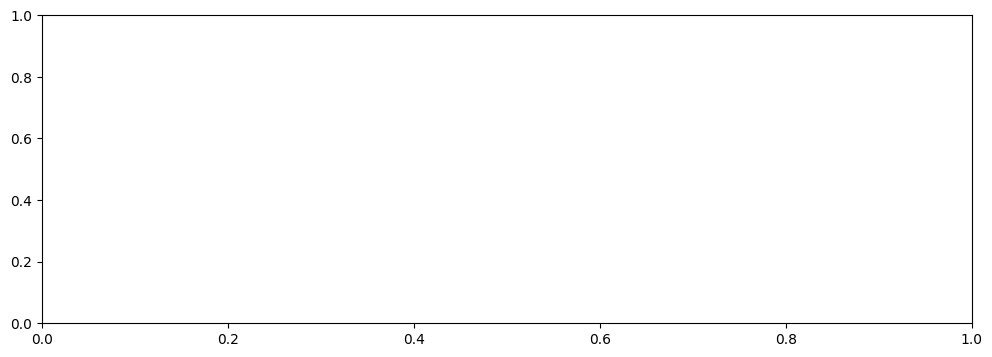

In [ ]:
xgb_path  ="/content/drive/MyDrive/kaggle/psp/model/mdoe41/XGB_fold0_question1.pickle"
import xgboost as xgb
import matplotlib.pyplot as plt

with open(xgb_path,"rb") as f:
  bst = pickle.load(f)
  _, ax = plt.subplots(figsize=(12, 4))
  xgb.plot_importance(bst[:200],ax=ax)

In [ ]:
import glob

def question_fe(num):

  path_list = glob.glob(f"/content/drive/MyDrive/kaggle/psp/model/mdoe41/*{i}.pickle")
  for path in path_list:
    with open(path,"rb") as f:
      xgb = pickle.load(f)
      bst = xgb.get_score(importance_type="gain")
      print(sorted(bst.items(),key=lambda x:x[1],reverse=True))


In [ ]:
question_fe(1)

[('person_click_ET_quantile3_', 239.78829956054688), ('basic_ET_quantile3_', 223.280517578125), ('person_click_ET_quantile2_', 172.40008544921875), ('worker_ET_quantile2_', 125.04166412353516), ('tunic.library.frontdesk.worker.wells_ET_quantile4_', 112.6480484008789), ('basic_ET_quantile2_', 92.1041030883789), ('tunic.library.frontdesk.worker.wells_ET_quantile5_', 83.82035827636719), ('tunic.drycleaner.frontdesk.worker.hub_ET_quantile3_', 73.29004669189453), ('basic_name_counts', 58.55376434326172), ('archivist_ET_quantile2_', 54.76026916503906), ('session_number_', 48.641239166259766), ('tunic.historicalsociety.frontdesk_room_fqid_counts', 46.93647766113281), ('close_ET_quantile6_', 40.99964904785156), ('tunic.library.frontdesk_room_fqid_counts', 39.50391387939453), ('tunic.drycleaner.frontdesk.worker.hub_ET_quantile2_', 38.762939453125), ('close_name_counts', 35.58975601196289), ('close_ET_sum_', 34.400596618652344), ('tunic.kohlcenter.halloffame_ET_mean_', 31.58624267578125), ('tuni

In [ ]:
bst_dic =  bst.get_score(importance_type="gain")
bst_dic = sorted(bst_dic.items(), key=lambda x:x[1],reverse=True)

In [ ]:
len(bst_dic)

886

In [ ]:
for i in range(19):
  path_list =
  for path in